Data frame shape: (26, 7)
Feature matrix shape: (26, 1)
PCA components used: 1 | explained variance sum: 1.0

=== K-MEANS ===


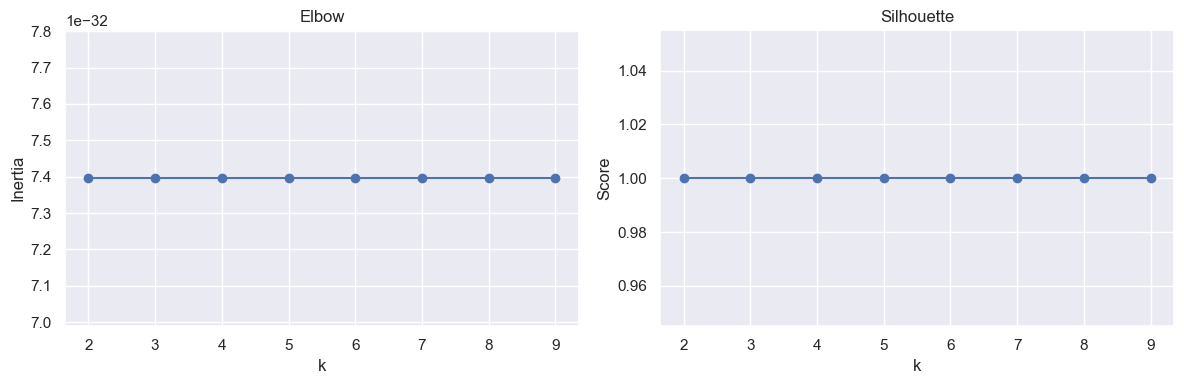

Selected k for KMeans: 2
KMeans silhouette: 1.0
KMeans cluster sizes: {0: 24, 1: 2}


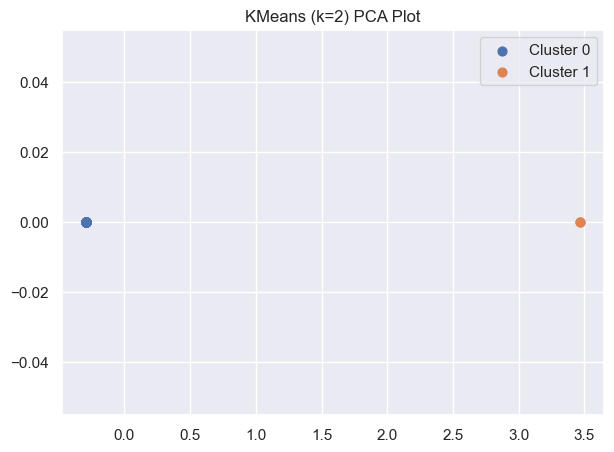


=== HIERARCHICAL (Agglomerative) ===
Hierarchical silhouette: 1.0
Hierarchical cluster sizes: {0: 24, 1: 2}


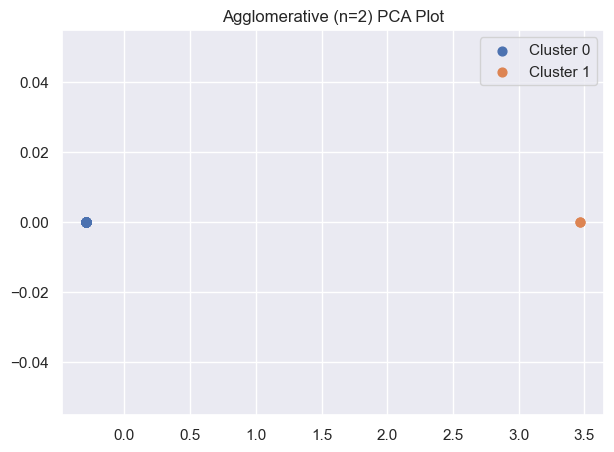


=== DBSCAN ===


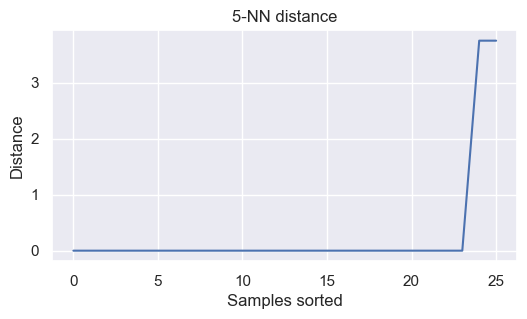

No valid DBSCAN clustering found with candidate eps/min_samples. Using default eps=0.5,min_samples=5
DBSCAN clusters (including -1 for noise): {-1: 2, 0: 24}
Noise points: 2


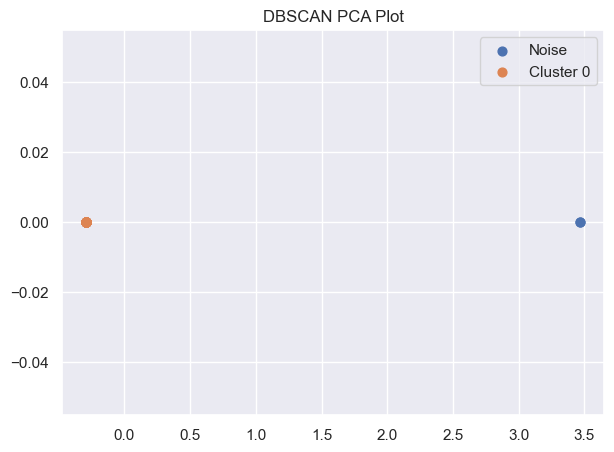


Saved clustered results to: C:\Users\abhin\EastWestAirlines_cluster_output.csv


In [8]:
# - KMEANS, HIERARCHICAL, DBSCAN
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.exceptions import ConvergenceWarning

# suppress only noisy warnings (we'll still show real errors)
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak on Windows with MKL")

sns.set()

# Confirm data exists
print("Data frame shape:", df.shape)
print("Feature matrix shape:", X.shape)

# ---------- PCA (safe dims) ----------
n_samples, n_features = X.shape
n_comp = min(2, n_samples, n_features)
if n_comp <= 0:
    raise ValueError("Not enough data (need at least 1 sample and 1 feature).")

pca = PCA(n_components=n_comp, random_state=42)
X_pca = pca.fit_transform(X)
print("PCA components used:", n_comp, "| explained variance sum:", round(pca.explained_variance_ratio_.sum(),4))

# ---------- K-MEANS ----------
print("\n=== K-MEANS ===")
K_max = min(10, max(3, n_samples))
K_range = range(2, K_max)
sil_scores = []
inertia = []
for k in K_range:
    try:
        km = KMeans(n_clusters=k, random_state=42, n_init=10)
        labs = km.fit_predict(X)
        inertia.append(km.inertia_)
        # silhouette requires >=2 clusters and >1 sample
        if len(np.unique(labs)) > 1 and n_samples > 1:
            sil_scores.append(silhouette_score(X, labs))
        else:
            sil_scores.append(np.nan)
    except Exception:
        inertia.append(np.nan)
        sil_scores.append(np.nan)

# plot elbow & silhouette if available
if any(~np.isnan(inertia)) and any(~np.isnan(sil_scores)):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1); plt.plot(list(K_range), inertia, marker='o'); plt.title("Elbow"); plt.xlabel("k"); plt.ylabel("Inertia")
    plt.subplot(1,2,2); plt.plot(list(K_range), sil_scores, marker='o'); plt.title("Silhouette"); plt.xlabel("k"); plt.ylabel("Score")
    plt.tight_layout(); plt.show()

# pick best k (fallback to 2)
if any(~np.isnan(sil_scores)):
    best_k = int(list(K_range)[int(np.nanargmax(sil_scores))])
else:
    best_k = 2 if n_samples >= 2 else 1

print("Selected k for KMeans:", best_k)
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
k_labels = kmeans.fit_predict(X)
k_sil = silhouette_score(X, k_labels) if len(np.unique(k_labels))>1 and n_samples>1 else np.nan
print("KMeans silhouette:", k_sil)
(unique, counts) = np.unique(k_labels, return_counts=True)
print("KMeans cluster sizes:", dict(zip(unique, counts)))

# KMeans PCA plot
plt.figure(figsize=(7,5))
if n_comp == 2:
    for lab in np.unique(k_labels):
        plt.scatter(X_pca[k_labels==lab,0], X_pca[k_labels==lab,1], s=40, label=f"Cluster {lab}")
else:
    for lab in np.unique(k_labels):
        mask = k_labels==lab
        plt.scatter(X_pca[mask,0], np.zeros(mask.sum()), s=40, label=f"Cluster {lab}")
plt.title(f"KMeans (k={best_k}) PCA Plot"); plt.legend(); plt.show()

df['KMeans_Cluster'] = k_labels

# ---------- HIERARCHICAL ----------
print("\n=== HIERARCHICAL (Agglomerative) ===")
# sklearn recent versions use metric instead of affinity for some linkages
n_clusters_h = best_k if best_k >= 1 else 1
if n_samples < n_clusters_h:
    n_clusters_h = max(1, n_samples)
hc = AgglomerativeClustering(n_clusters=n_clusters_h, metric='euclidean', linkage='ward')
h_labels = hc.fit_predict(X)
df['Hierarchical_Cluster'] = h_labels

h_sil = silhouette_score(X, h_labels) if len(np.unique(h_labels))>1 and n_samples>1 else np.nan
print("Hierarchical silhouette:", h_sil)
(unique, counts) = np.unique(h_labels, return_counts=True)
print("Hierarchical cluster sizes:", dict(zip(unique, counts)))

plt.figure(figsize=(7,5))
if n_comp == 2:
    for lab in np.unique(h_labels):
        plt.scatter(X_pca[h_labels==lab,0], X_pca[h_labels==lab,1], s=40, label=f"Cluster {lab}")
else:
    for lab in np.unique(h_labels):
        mask = h_labels==lab
        plt.scatter(X_pca[mask,0], np.zeros(mask.sum()), s=40, label=f"Cluster {lab}")
plt.title(f"Agglomerative (n={n_clusters_h}) PCA Plot"); plt.legend(); plt.show()

# ---------- DBSCAN ----------
print("\n=== DBSCAN ===")
db_labels = np.array([-1]*n_samples)  # default fallback

if n_samples <= 1:
    print("Too few samples for DBSCAN; skipping DBSCAN clustering.")
else:
    # compute k-distance
    k_nn = min(5, max(2, n_samples-1))
    nbrs = NearestNeighbors(n_neighbors=k_nn).fit(X)
    distances, _ = nbrs.kneighbors(X)
    kdist = np.sort(distances[:, k_nn-1])
    plt.figure(figsize=(6,3)); plt.plot(kdist); plt.title(f"{k_nn}-NN distance"); plt.xlabel("Samples sorted"); plt.ylabel("Distance"); plt.show()

    # Build candidate eps values robustly (skip zeros)
    p5 = np.percentile(kdist, 5)
    p80 = np.percentile(kdist, 80)
    # ensure positive range
    if p80 <= 0 and np.any(kdist > 0):
        p80 = np.max(kdist)
    if p5 <= 0:
        # try smallest positive value in kdist
        pos = kdist[kdist > 0]
        p5 = pos.min() if pos.size > 0 else 0.0

    # If still zero or no positive distances, we cannot tune eps; fallback to simple DBSCAN decision
    if p5 <= 0 and p80 <= 0:
        print("k-distance values are zero (many duplicate rows). Skipping DBSCAN tuning.")
        db_labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(X)
    else:
        # form eps candidate list avoiding zeros
        eps_values = np.linspace(max(p5, 1e-6), max(p80, max(p5, 1e-6)), 6)
        eps_values = [float(e) for e in eps_values if e > 0]
        min_samples_list = [3,5,7]
        best = {"score": -1, "labels": None, "params": None}

        for eps in eps_values:
            for ms in min_samples_list:
                if ms >= n_samples:
                    continue
                try:
                    labs = DBSCAN(eps=eps, min_samples=ms).fit_predict(X)
                    n_clusters = len(set(labs)) - (1 if -1 in labs else 0)
                    mask = labs != -1
                    if n_clusters <= 0 or mask.sum() <= 1:
                        continue
                    sc = silhouette_score(X[mask], labs[mask])
                    # store best
                    if sc > best["score"]:
                        best = {"score": sc, "labels": labs, "params": (eps, ms)}
                except Exception:
                    continue

        if best["labels"] is not None:
            db_labels = best["labels"]
            print("Best DBSCAN params:", (round(best["params"][0],6), best["params"][1]), "silhouette:", round(best["score"],4))
        else:
            print("No valid DBSCAN clustering found with candidate eps/min_samples. Using default eps=0.5,min_samples=5")
            db_labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(X)

df['DBSCAN_Cluster'] = db_labels
noise_count = int((db_labels == -1).sum())
(unique, counts) = np.unique(db_labels, return_counts=True)
print("DBSCAN clusters (including -1 for noise):", dict(zip(unique, counts)))
print("Noise points:", noise_count)

plt.figure(figsize=(7,5))
for lab in np.unique(db_labels):
    mask = db_labels==lab
    name = "Noise" if lab == -1 else f"Cluster {lab}"
    if n_comp == 2:
        plt.scatter(X_pca[mask,0], X_pca[mask,1], s=40, label=name)
    else:
        plt.scatter(X_pca[mask,0], np.zeros(mask.sum()), s=40, label=name)
plt.title("DBSCAN PCA Plot"); plt.legend(); plt.show()

# ---------- SAVE ----------
out_file = "EastWestAirlines_cluster_output.csv"
df.to_csv(out_file, index=False)
print("\nSaved clustered results to:", os.path.abspath(out_file))
